In [1]:
import numpy as np

# from tensorflow.python import pywrap_tensorflow
import scipy as sp
from scipy import misc, linalg

import matplotlib.pylab as plt
%matplotlib inline

# import tt

# Signal quantization

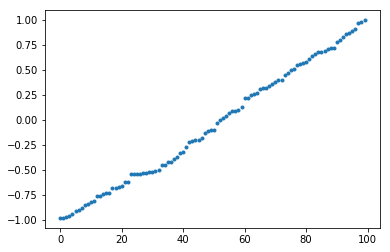

In [3]:
# generate signal
x = np.array(sorted(2*np.random.random(size = 100) - 1))
x[:10]
plt.plot(x, '.')

mu transformed:  [-0.99600547 -0.99573485 -0.99520831 -0.99319819 -0.98819435 -0.98379892
 -0.98051009 -0.9773511  -0.97052157 -0.969024  ]


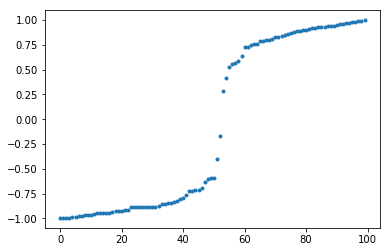

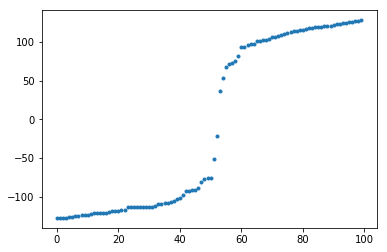

discretized:  [-128. -128. -128. -128. -127. -126. -126. -126. -125. -125.]


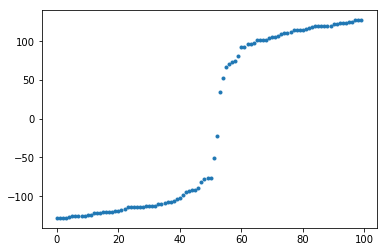

scaled:  [-1.        -1.        -1.        -1.        -0.9921875 -0.984375
 -0.984375  -0.984375  -0.9765625 -0.9765625]


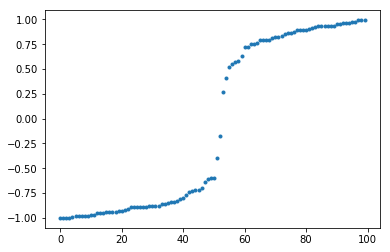

In [5]:
# apply mu transformation
mu = 255
x_quantized = np.sign(x)*np.log(1 + mu*np.abs(x))/np.log(1 + mu)
print('mu transformed: ', x_quantized[:10])
plt.plot(x_quantized, '.')
plt.show()

# discretize 
x_quantized = x_quantized*128
plt.plot(x_quantized, '.')
plt.show()

x_quantized = np.floor(x_quantized)
print('discretized: ', x_quantized[:10])
plt.plot(x_quantized, '.')
plt.show()


# scale
x_quantized = x_quantized/128
print('scaled: ', x_quantized[:10])
plt.plot(x_quantized, '.')
plt.show()

Do I understand correctly that this transformation is made for the following purpuses:

- we want to discretise an initial signal
- we want to discretize it in such way to pay more attention to the intervals with high amplitudes (as I inderstand this is made to ignore detailed exploration of noise that is usually has lower amplitude that informative signal) 

In [37]:
len(set(x_quantized))

256

# Load pretrained weigths

Analize weights for two models:

    1) WaveNet autoencoder pretrained by magenta team
    2) Wavenet pretrained by some guy https://github.com/ibab/tensorflow-wavenet/issues/18
    3) WaveNet original, but trained not till the end https://github.com/ibab/tensorflow-wavenet/issues/307
    

In [115]:
def load_weights(model_path):

    reader = pywrap_tensorflow.NewCheckpointReader(model_path)

    weights = {}
    for key in reader.get_variable_to_shape_map().keys():
        weights[key] = reader.get_tensor(key)
    return weights

def get_2d_weights(weights):
#     input: 4d arrays - weights of shape (1, filter_width, C_in, C_out)
#     output: 2d arrays - reshaped weights (C_out, filter_width*C_in) from encoder layers 
    
    weights_2d = {}
    
#     # for WaveNet autoencoder
#     for key in sorted(filter(lambda key:  key.startswith('ae') and key.endswith("W"),
#                          weights.keys())):
#     # for WaveNet small
#     for key in sorted(filter(lambda key:  key.split('/')[-1].startswith('Adam') and
#                          key.startswith('wavenet'), weights.keys())):

    # for WaveNet original
    for key in sorted(filter(lambda key:  not key.split("/")[-1].startswith('Variable'),
                         weights.keys())):

        try:
            A = np.array([weights[key][0,:,:,i].ravel() for i in range(weights[key].shape[-1])])
        except:
            if len(weights[key].shape) > 2:
                
                A = np.array([weights[key][:,:,i].ravel() for i in range(weights[key].shape[-1])])
            else:
                continue
            
        weights_2d[key] = A
        
    return weights_2d

In [116]:
# OLD_MODEL_PATH = '/home/julia/DeepVoice_data/wavenet-voice-ckpt/model.ckpt-200000'
# OLD_MODEL_PATH = '/home/julia/DeepVoice_data/wavenet-small-ckpt/model.ckpt-1950'
OLD_MODEL_PATH = '/home/julia/DeepVoice_data/wavenet-original-ckpt-2017-12-04T13-48-11/model.ckpt-12000'

weights = load_weights(OLD_MODEL_PATH)

weights_2d = get_2d_weights(weights)

In [118]:
for key in sorted(weights_2d.keys()):
    print(key, weights[key].shape)

wavenet/causal_layer/filter (2, 256, 32)
wavenet/dilated_stack/layer0/dense (1, 32, 32)
wavenet/dilated_stack/layer0/filter (2, 32, 32)
wavenet/dilated_stack/layer0/gate (2, 32, 32)
wavenet/dilated_stack/layer0/gc_filter (1, 32, 32)
wavenet/dilated_stack/layer0/gc_gate (1, 32, 32)
wavenet/dilated_stack/layer0/skip (1, 32, 512)
wavenet/dilated_stack/layer1/dense (1, 32, 32)
wavenet/dilated_stack/layer1/filter (2, 32, 32)
wavenet/dilated_stack/layer1/gate (2, 32, 32)
wavenet/dilated_stack/layer1/gc_filter (1, 32, 32)
wavenet/dilated_stack/layer1/gc_gate (1, 32, 32)
wavenet/dilated_stack/layer1/skip (1, 32, 512)
wavenet/dilated_stack/layer10/dense (1, 32, 32)
wavenet/dilated_stack/layer10/filter (2, 32, 32)
wavenet/dilated_stack/layer10/gate (2, 32, 32)
wavenet/dilated_stack/layer10/gc_filter (1, 32, 32)
wavenet/dilated_stack/layer10/gc_gate (1, 32, 32)
wavenet/dilated_stack/layer10/skip (1, 32, 512)
wavenet/dilated_stack/layer11/dense (1, 32, 32)
wavenet/dilated_stack/layer11/filter (2, 

In [94]:
W = weights_2d[list(weights_2d.keys())[-5]]
WW = weights[list(weights_2d.keys())[-5]]

print(W.shape, WW.shape)

(32, 32) (1, 32, 32)


In [95]:
tt.tensor(W,eps=1e-3)

This is a 2-dimensional tensor 
r(0)=1, n(0)=32 
r(1)=32, n(1)=32 
r(2)=1 

In [96]:
tt.tensor(WW,eps=1e-3)

This is a 3-dimensional tensor 
r(0)=1, n(0)=1 
r(1)=1, n(1)=32 
r(2)=32, n(2)=32 
r(3)=1 

In [58]:
Wd = W.reshape([2]*7 + [1] + [2]*7, order='F')
Wd.shape

ValueError: cannot reshape array of size 1024 into shape (2,2,2,2,2,2,2,1,2,2,2,2,2,2,2)

In [34]:
tt.tensor(Wd, eps = 1e-3)

This is a 15-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=2, n(1)=2 
r(2)=4, n(2)=2 
r(3)=8, n(3)=2 
r(4)=16, n(4)=2 
r(5)=32, n(5)=2 
r(6)=64, n(6)=2 
r(7)=128, n(7)=1 
r(8)=128, n(8)=2 
r(9)=64, n(9)=2 
r(10)=32, n(10)=2 
r(11)=16, n(11)=2 
r(12)=8, n(12)=2 
r(13)=4, n(13)=2 
r(14)=2, n(14)=2 
r(15)=1 

##### Count rank of matrix with np.linalg.matrix (uses SVD) 

In [97]:
for key,W in weights_2d.items():
    rank = np.linalg.matrix_rank(W, tol = 0.01)
    print('{}: flattened shape = {}, rank = {} '.format(key, W.shape,  rank))

wavenet/causal_layer/filter: flattened shape = (32, 512), rank = 32 
wavenet/dilated_stack/layer0/filter: flattened shape = (32, 64), rank = 32 
wavenet/dilated_stack/layer0/gc_filter: flattened shape = (32, 32), rank = 32 
wavenet/dilated_stack/layer1/filter: flattened shape = (32, 64), rank = 32 
wavenet/dilated_stack/layer1/gc_filter: flattened shape = (32, 32), rank = 31 
wavenet/dilated_stack/layer10/filter: flattened shape = (32, 64), rank = 32 
wavenet/dilated_stack/layer10/gc_filter: flattened shape = (32, 32), rank = 32 
wavenet/dilated_stack/layer11/filter: flattened shape = (32, 64), rank = 32 
wavenet/dilated_stack/layer11/gc_filter: flattened shape = (32, 32), rank = 32 
wavenet/dilated_stack/layer12/filter: flattened shape = (32, 64), rank = 32 
wavenet/dilated_stack/layer12/gc_filter: flattened shape = (32, 32), rank = 32 
wavenet/dilated_stack/layer13/filter: flattened shape = (32, 64), rank = 32 
wavenet/dilated_stack/layer13/gc_filter: flattened shape = (32, 32), rank

# Find low rank approximation

### Using SVD  

In [60]:
def component(i, U, D, V):
#   output: main component
    u = U.T[i].reshape(-1, 1)
    v = V[i].reshape(-1, 1)
    return u.dot(v.T)*D[i]

def count_approx(components, U, D, V):
#   output: sum of components
    approx = np.zeros(component(0, U, D, V).shape)
    
    for i in range(0, components[-1] + 1):
        approx = approx + component(i, U, D, V)
        
    return approx

In [98]:
for key,W in weights_2d.items():
    W_new = W - W.mean(axis = 0)[np.newaxis, :]

    U, D, V = np.linalg.svd(W_new, full_matrices=False)
#     print('{}: U.shape = {}, D.shape = {}, V.shape = {}'.format(key, U.shape, D.shape, V.shape))
    components = np.arange(min(100, D.shape[0]))
    
    approx = count_approx(components, U, D, V)
    norm = np.linalg.norm(W_new - approx)
    print('{}: n_components = {}, norm = {}'.format(key, len(components), norm))

wavenet/causal_layer/filter: n_components = 32, norm = 2.126295177335606e-06
wavenet/dilated_stack/layer0/filter: n_components = 32, norm = 6.138060372897569e-07
wavenet/dilated_stack/layer0/gc_filter: n_components = 32, norm = 1.893714806083122e-07
wavenet/dilated_stack/layer1/filter: n_components = 32, norm = 4.906611663781894e-07
wavenet/dilated_stack/layer1/gc_filter: n_components = 32, norm = 2.3148515220887378e-07
wavenet/dilated_stack/layer10/filter: n_components = 32, norm = 5.137033524084679e-07
wavenet/dilated_stack/layer10/gc_filter: n_components = 32, norm = 2.116540497481867e-07
wavenet/dilated_stack/layer11/filter: n_components = 32, norm = 5.140833282017321e-07
wavenet/dilated_stack/layer11/gc_filter: n_components = 32, norm = 2.742519582918607e-07
wavenet/dilated_stack/layer12/filter: n_components = 32, norm = 4.809518091581871e-07
wavenet/dilated_stack/layer12/gc_filter: n_components = 32, norm = 2.8920407511812084e-07
wavenet/dilated_stack/layer13/filter: n_components

### Constructing matrix $Q$ such that its linear span of columns approximates image of initial matrix

Везде ниже $||\cdot||_2$ --- это операторная $l_2$-норма.

Зафиксируем некоторое $\varepsilon > 0$. Найти низкоранговое приближение матрицы $A$ с точностью $\varepsilon$ --- значит найти такую матрицу $Q$ с $k = k(\varepsilon)$ ортонормированными столбцами, для которой
$$
\begin{matrix}
\phantom{AAAAAAAAAAAAAAAAA} &
||A - QQ^TA||_2 < \varepsilon & \phantom{AAAAAAAAAAAAaa}(1)\end{matrix}$$
В этом случае линейная оболочка столбцов матрицы $Q$ является в каком-то смысле приближённым образом $A$.

Если ранг $k$ нам из каких-то соображений известен, то можно воспользоваться, например, сингулярным разложением. А если нет? Есть способ этот ранг найти; 

Идея: если мы возьмём образы достаточно большого количества случайных векторов (обычно их берут из стандартного
нормального распределения), с хорошей вероятностью их линейная оболочка будет приближать образ с нужной нам точностью. Главный вопрос в том, когда имеет смысл остановиться. И здесь помогает следующая

**Теорема.** Пусть $B\in\mathrm{Mat}_{m\times n}$ --- некоторая матрица, $\omega_1,\ldots,\omega_r$ --- случайные векторы, независимо выбранные из стандартного нормального распределения. Тогда
$$P\left\{||B||\leqslant 10\sqrt{\frac{2}{\pi}}\max_i{||B\omega_i||}\right\} \geqslant 1 - \min(m,n)\cdot10^{-r}$$



##### Реализация
Функция `find_approximate(A, eps)`, находит для данной матрицы $A$ и уровня точности $\varepsilon$ матрицу $Q$, удовлетворяющую условию (1).

Генерируем $k$ случайных векторов $x_1,...,x_k$ длины $n$ из стандартного нормального распределения. Из образов $A x_1,...,A x_k$ составляем матрицу $preQ$.

У матрица $preQ$ в $i$-ом столбце стоит вектор $A x_i$. Объект $preQ^T$ - список векторов

С помощью ортогонализации Грамма-Шмидта находим набор ортонормированных векторов, которые образуют ту же линейную оболочку, что и векторы из $preQ$.

$Q$ - матрица, составленная из ортогонализованных векторов, является кандидатом в приближенный образ матрицы $A$.

Считаем норму матрицы $A - Q Q^T A$, генерируя $r$ векторов $w_i$ и выбирая максимум из $||A w_i||*coeff$, где $coeff = 10 \sqrt(2/pi)$.

Если норма меньше $\epsilon$, увеличиваем $k$ на 1, повторяем процесс с начала.

In [79]:
def build_preQ(A, x):
    n = A.shape[1]
    preQ = A.dot(x[0].reshape((n, 1)))
    for xi in x[1:]:
        preQ = np.append(preQ, A.dot(xi.reshape((n, 1))), axis = 1)
    return preQ

# Ортогонализация Грамма-Шмидта
def gs_cofficient(v1, v2):
    return np.dot(v2, v1) / np.dot(v1, v1)

def multiply(cofficient, v):
    return list(map((lambda x : x * cofficient), v))

def proj(v1, v2):
    return multiply(gs_cofficient(v1, v2) , v1)

def gs(X):
    Y = []
    for i in range(len(X)):
        temp_vec = X[i]
        for inY in Y :
            proj_vec = proj(inY, X[i])
            temp_vec = list(map(lambda x, y : x - y, temp_vec, proj_vec))
        Y.append(temp_vec)
    return Y


def count_norm(A, Q, r):
    n = A.shape[1]
    M = A - Q.dot(Q.T).dot(A)
    w = np.random.randn(r, n)
    coeff = 10 * np.sqrt(2/np.pi)
    return np.max(list(map(lambda wi : np.linalg.norm(M.dot(wi.reshape(n, 1))), w))) * coeff

def find_approximate(A, eps):
    k = 1
    n = A.shape[1]
    x = np.random.randn(k, n)
    norm = eps + 0.000000001
    norms = []
    while norm > eps:
        preQ = build_preQ(A, x)
        # Q = np.asarray(gs(preQ.T)).T
        Q = sp.linalg.orth(preQ)
        norm = count_norm(A, Q, 1)
        norms.append(norm)
        
        k += 1
        x = np.append(x, np.random.randn(1, n), axis = 0)
        # x = np.random.randn(k, n)
    return k - 1, norms

def plot_norm_k(norms):
    plt.plot(norms)  
    plt.show()

In [123]:
eps = 0.01

for key in sorted(weights_2d.keys()):
    W = weights_2d[key]
    # optional 
    W = (W.dot(W.T)).dot(W.dot(W.T)).dot(W)
    
    k, norms = find_approximate(W, eps)
    
    print('{}: shape = {}, rank = {}'.format(key, weights[key].shape, k))
#     plot_norm_k(norms)

wavenet/causal_layer/filter: shape = (2, 256, 32), rank = 32
wavenet/dilated_stack/layer0/dense: shape = (1, 32, 32), rank = 29
wavenet/dilated_stack/layer0/filter: shape = (2, 32, 32), rank = 32
wavenet/dilated_stack/layer0/gate: shape = (2, 32, 32), rank = 32
wavenet/dilated_stack/layer0/gc_filter: shape = (1, 32, 32), rank = 21
wavenet/dilated_stack/layer0/gc_gate: shape = (1, 32, 32), rank = 25
wavenet/dilated_stack/layer0/skip: shape = (1, 32, 512), rank = 32
wavenet/dilated_stack/layer1/dense: shape = (1, 32, 32), rank = 26
wavenet/dilated_stack/layer1/filter: shape = (2, 32, 32), rank = 32
wavenet/dilated_stack/layer1/gate: shape = (2, 32, 32), rank = 32
wavenet/dilated_stack/layer1/gc_filter: shape = (1, 32, 32), rank = 25
wavenet/dilated_stack/layer1/gc_gate: shape = (1, 32, 32), rank = 24
wavenet/dilated_stack/layer1/skip: shape = (1, 32, 512), rank = 32
wavenet/dilated_stack/layer10/dense: shape = (1, 32, 32), rank = 27
wavenet/dilated_stack/layer10/filter: shape = (2, 32, 3

wavenet/dilated_stack/layer26/skip: shape = (1, 32, 512), rank = 32
wavenet/dilated_stack/layer27/dense: shape = (1, 32, 32), rank = 28
wavenet/dilated_stack/layer27/filter: shape = (2, 32, 32), rank = 32
wavenet/dilated_stack/layer27/gate: shape = (2, 32, 32), rank = 32
wavenet/dilated_stack/layer27/gc_filter: shape = (1, 32, 32), rank = 27
wavenet/dilated_stack/layer27/gc_gate: shape = (1, 32, 32), rank = 29
wavenet/dilated_stack/layer27/skip: shape = (1, 32, 512), rank = 32
wavenet/dilated_stack/layer28/dense: shape = (1, 32, 32), rank = 29
wavenet/dilated_stack/layer28/filter: shape = (2, 32, 32), rank = 32
wavenet/dilated_stack/layer28/gate: shape = (2, 32, 32), rank = 32
wavenet/dilated_stack/layer28/gc_filter: shape = (1, 32, 32), rank = 29
wavenet/dilated_stack/layer28/gc_gate: shape = (1, 32, 32), rank = 29
wavenet/dilated_stack/layer28/skip: shape = (1, 32, 512), rank = 32
wavenet/dilated_stack/layer29/dense: shape = (1, 32, 32), rank = 28
wavenet/dilated_stack/layer29/filter

wavenet/dilated_stack/layer44/skip: shape = (1, 32, 512), rank = 32
wavenet/dilated_stack/layer45/dense: shape = (1, 32, 32), rank = 28
wavenet/dilated_stack/layer45/filter: shape = (2, 32, 32), rank = 32
wavenet/dilated_stack/layer45/gate: shape = (2, 32, 32), rank = 32
wavenet/dilated_stack/layer45/gc_filter: shape = (1, 32, 32), rank = 26
wavenet/dilated_stack/layer45/gc_gate: shape = (1, 32, 32), rank = 28
wavenet/dilated_stack/layer45/skip: shape = (1, 32, 512), rank = 32
wavenet/dilated_stack/layer46/dense: shape = (1, 32, 32), rank = 29
wavenet/dilated_stack/layer46/filter: shape = (2, 32, 32), rank = 32
wavenet/dilated_stack/layer46/gate: shape = (2, 32, 32), rank = 32
wavenet/dilated_stack/layer46/gc_filter: shape = (1, 32, 32), rank = 27
wavenet/dilated_stack/layer46/gc_gate: shape = (1, 32, 32), rank = 30
wavenet/dilated_stack/layer46/skip: shape = (1, 32, 512), rank = 32
wavenet/dilated_stack/layer47/dense: shape = (1, 32, 32), rank = 28
wavenet/dilated_stack/layer47/filter

# Plot eigen values

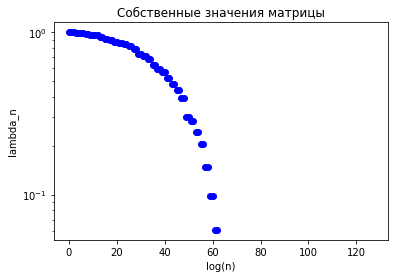

[(1+0j), (0.9998178+0.019089652j), (0.9998178-0.019089652j), (0.9961887+0.0872244j), (0.9961887-0.0872244j), (0.9868599+0.16157821j), (0.9868599-0.16157821j), (0.979332+0.20225932j), (0.979332-0.20225932j), (0.9629081+0.26982954j), (0.9629081-0.26982954j), (0.9556773+0.29441637j), (0.9556773-0.29441637j), (0.9324729+0.36124003j), (0.9324729-0.36124003j), (0.90613663+0.42298514j), (0.90613663-0.42298514j), (0.898288+0.43940714j), (0.898288-0.43940714j), (0.8764042+0.48157617j), (0.8764042-0.48157617j), (0.8583102+0.51313114j), (0.8583102-0.51313114j), (0.8511122+0.5249838j), (0.8511122-0.5249838j), (0.8244071+0.5659973j), (0.8244071-0.5659973j), (0.791592+0.61105j), (0.791592-0.61105j), (0.73933417+0.6733387j), (0.73933417-0.6733387j), (0.7161646+0.69793147j), (0.7161646-0.69793147j), (0.6799769+0.7332336j), (0.6799769-0.7332336j), (0.63277584+0.774335j), (0.63277584-0.774335j), (0.5940313+0.8044419j), (0.5940313-0.8044419j), (0.5668511+0.8238203j), (0.5668511-0.8238203j), (0.52637905+0

In [66]:
eig_values, eig_vectors = np.linalg.eig(V)
eig_sorted = list(sorted(eig_values, reverse = True))
plt.semilogy(np.real(eig_sorted), 'bo')
plt.title(u'Cобственные значения матрицы')
plt.ylabel(u'lambda_n')
plt.xlabel(u'log(n)')

plt.show()
print(eig_sorted)

In [126]:
k = 2
n = 5
b = 3
nb = 1
N = nb*k*b*n

x = np.arange(nb*k*b*n).reshape((nb, n, k*b)).transpose(0, 2, 1)
y = 10*np.arange(nb*k*b*n).reshape((nb, n, k*b)).transpose(0, 2, 1)
print(x.shape, y.shape)

z = np.array([[np.arange(nbj, N-k*b+jn, k*b) for jn in range(n + 1)] for nbj in range(nb)])
# z = np.concatenate([x, y])
print(z.shape)

z[0, :, 0], z[0, 0, :], z[0, :, 0]
# x = [np.aran,ge(k*b), np.arange(k*b, 2*k*b), np.arange(2*k*b, 3*k*b)]

(1, 6, 5) (1, 6, 5)
(1, 6)


IndexError: too many indices for array

In [3]:
import tt
import numpy as np

In [33]:
x = np.arange(-512, 512, 1)/512
print(x.shape)

f = np.exp(x) + np.exp(2*x)

(1024,)


In [34]:
f = f.reshape([2]*10)

In [35]:
ttv = tt.vector(f, eps = 1e-5)

In [36]:
ttv.to_list(ttv)

[array([[[ -25.83533381,   -1.41883793],
         [-122.31753009,    0.29968028]]]), array([[[ 0.40551858,  0.00539585],
         [ 0.91406773, -0.00239818]],
 
        [[ 0.74603392,  0.26711879],
         [-0.33120469,  0.5122347 ]]]), array([[[ 0.55174593, -0.00154524],
         [ 0.83401018,  0.00102388]],
 
        [[ 0.71182386, -0.30383398],
         [-0.47095587, -0.42331108]]]), array([[[ 6.30619316e-01, -3.82499363e-04],
         [ 7.76092157e-01,  3.11085282e-04]],
 
        [[-6.69703868e-01,  3.26476288e-01],
         [ 5.44179035e-01,  3.85718992e-01]]]), array([[[ 6.69499340e-01, -9.29698850e-05],
         [ 7.42812640e-01,  8.38334999e-05]],
 
        [[-6.42791809e-01,  3.39298323e-01],
         [ 5.79351092e-01,  3.68846378e-01]]]), array([[[ 6.88503296e-01, -2.27520911e-05],
         [ 7.25233211e-01,  2.16049258e-05]],
 
        [[-6.28235794e-01,  3.45822080e-01],
         [ 5.96418485e-01,  3.60571582e-01]]]), array([[[ 6.97860021e-01, -5.59019760e-06],
         [